In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from scipy import stats 
plot_list = []

In [69]:
def get_col_num(df):
    return df.columns.size

In [70]:
def get_row_num(df):
    return df.size / get_col_num(df)

In [71]:
def get_entropy(px):
    if px == 0:
        return 0;
    return px * np.log2(px)

In [72]:
def getParentEntropy(dataFrame) :
    row_num = get_row_num(dataFrame)
    col_num = get_col_num(dataFrame)
    idx = pd.RangeIndex(start=0, stop=row_num)
    dataFrame.index=idx
    confirmed_person = dataFrame.loc[dataFrame["식전혈당(공복혈당)"] >= 126]
    confirmed_mask = dataFrame["식전혈당(공복혈당)"] >= 126
    confirmed_size = confirmed_person.size / col_num
    unconfirmed_person = dataFrame.loc[dataFrame["식전혈당(공복혈당)"] < 126]
    unconfirmed_size = row_num - confirmed_size
    confirmed_px_root = confirmed_size / row_num
    unconfirmed_px_root = 1 - confirmed_px_root
    entropy_root = -1 * (get_entropy(confirmed_px_root) + get_entropy(unconfirmed_px_root))
    return entropy_root

In [73]:
def getIG(dataFrame, col_name, value_list):
    sum_entropy = 0
    col_num = get_col_num(dataFrame)
    row_num = get_row_num(dataFrame)
    for val in value_list:
        df = dataFrame.loc[dataFrame[col_name] == val]
        df_size = df.size / col_num
        
        Y_df = df.loc[df["식전혈당(공복혈당)"] >= 126]
        
        Y_df_size = Y_df.size / col_num
        
        Y_px = Y_df_size / df_size
        N_px = 1 - Y_px
        rtn = -1 * (get_entropy(Y_px) + get_entropy(N_px))
        sum_entropy += rtn * (df_size / row_num)
    print("H(%s):"%(col_name), sum_entropy)
    return getParentEntropy(dataFrame) - sum_entropy

In [74]:
def getRangeIG(dataFrame, col_name, range_list):
    global plot_list
    sum_entropy = 0
    prev_ran = 0
    col_num = get_col_num(dataFrame)
    row_num = get_row_num(dataFrame)
    for ran in range_list:
        df = dataFrame.loc[dataFrame[col_name] > prev_ran]
        df = df.loc[df[col_name] <= ran] 
        plot_list.append(len(df))
        df_size = df.size / col_num
        
        Y_df = df.loc[df["식전혈당(공복혈당)"] >= 126]
        
        Y_df_size = Y_df.size / col_num
        
        Y_px = Y_df_size / df_size
        N_px = 1 - Y_px
        
        rtn = -1 * (get_entropy(Y_px) + get_entropy(N_px))
        sum_entropy += rtn * (df_size / row_num)
        prev_ran = ran
    print("H(%s): "%(col_name), sum_entropy)
    return getParentEntropy(dataFrame) - sum_entropy

In [75]:
df_17 = pd.read_csv('../PBL/dataset/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2017_100.csv', encoding='euc-kr')
df_18 = pd.read_csv('../PBL/dataset/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2018_100.csv')

In [124]:
valid_17 = df_17.copy()
valid_18 = df_18.copy()

In [125]:
valid_18["음주여부"].fillna(0, inplace=True)

In [126]:
drop_list = ['기준년도', '가입자일련번호', '시도코드', '청력(좌)', '청력(우)', '시력(좌)', '시력(우)', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석', '데이터공개일자', '총콜레스테롤', 'LDL콜레스테롤', 'HDL콜레스테롤', '트리글리세라이드']

In [127]:
valid_df = pd.concat([valid_17, valid_18])
valid_df.drop(columns=drop_list, inplace=True)
valid_df.dropna(inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [128]:
add_col = valid_df['식전혈당(공복혈당)'].copy()
add_col[add_col < 126] = 0
add_col[add_col >= 126] = 1
valid_df['당뇨여부'] = add_col

In [129]:
def z_score_method(df, variable_name):
    #Takes two parameters: dataframe & variable of interest as string
    columns = df.columns

    z = np.abs(stats.zscore(df))
     
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index = item
    for i, v in enumerate(z[:, index]):
        if v > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

In [131]:
copytest = valid_df.copy()
# copytest["식전혈당(공복혈당)"] = round(copytest["식전혈당(공복혈당)"])
outlier_z = z_score_method(copytest, "식전혈당(공복혈당)")
print(len(outlier_z))
print(len(copytest))
valid_df = copytest.drop(copytest.index[outlier_z])
print(len(valid_df))

36458
1983201
1946743


In [11]:
# print(valid_df["성별코드"].unique())
print("정보획득량: " , getIG(valid_df, "성별코드", valid_df["성별코드"].unique()))

H(성별코드): 0.3103623922991349
정보획득량:  0.021873448000680418


In [12]:
# print(valid_df["연령대코드(5세단위)"].unique())
print("정보획득량: ", getIG(valid_df, "연령대코드(5세단위)", valid_df["연령대코드(5세단위)"].unique()))

H(연령대코드(5세단위)): 0.29425177111545964
정보획득량:  0.03798406918435571


In [13]:
# print(valid_df["신장(5Cm단위)"].unique())
print("정보획득량: ", getIG(valid_df, "신장(5Cm단위)", valid_df["신장(5Cm단위)"].unique()))

H(신장(5Cm단위)): 0.3134086768038382
정보획득량:  0.01882716349597713


In [14]:
print("정보획득량: ", getIG(valid_df, "체중(5Kg단위)", valid_df["체중(5Kg단위)"].unique()))

H(체중(5Kg단위)): 0.3092669199110947
정보획득량:  0.02296892038872067


H(BMI):  0.38371518024797446
정보획득량:  0.012028642959530267
[1231087, 666204, 82503]


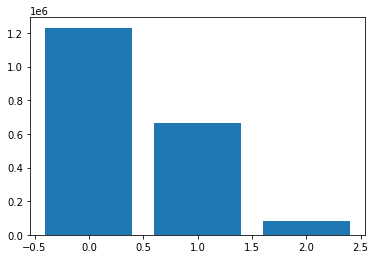

In [20]:
bmi_ref = valid_df.loc[:,["체중(5Kg단위)", "신장(5Cm단위)"]]
bmi_df = (bmi_ref["체중(5Kg단위)"] / ((bmi_ref["신장(5Cm단위)"]/100)**2))
bmi_df = round(bmi_df)

copy_df_bmi = valid_df.copy()
copy_df_bmi.insert(get_col_num(copy_df_bmi), 'BMI', bmi_df)

bmi_list = [24.9, 29.9, 34.9]

plot_list = []
print("정보획득량: ", getRangeIG(copy_df_bmi, "BMI", bmi_list))
print(plot_list)
plt.bar(range(len(np.array(plot_list))), np.array(plot_list))
plt.show()



In [16]:
copy_df_waist = valid_df.copy()
copy_df_waist.dropna(subset=["허리둘레"], inplace=True)
copy_df_waist = copy_df_waist.loc[copy_df_waist["허리둘레"] >= 35]
copy_df_waist = copy_df_waist.loc[copy_df_waist["허리둘레"] <= 111.76]

waist_list = [66.04, 71.12, 78.74, 83.82, 104.14, 106.68, 111.76]

print("정보획득량: ", getRangeIG(copy_df_waist, "허리둘레", waist_list))




H(허리둘레):  0.3623876276400057
정보획득량:  0.018175843898836974


In [58]:
man_df = valid_df.loc[valid_df["성별코드"] == 1].copy()
woman_df = valid_df.loc[valid_df["성별코드"] == 2].copy()

man_df.dropna(subset=["감마지티피"], inplace=True)
woman_df.dropna(subset=["감마지티피"], inplace=True)

man_range= [10, 63, 99, 199, 599, 1000]
woman_range = [7, 35, 99, 199, 599, 1000]

print(getRangeIG(man_df, "감마지티피", man_range))
print(getRangeIG(woman_df, "감마지티피", woman_range))


H(감마지티피):  0.4501248726610595
0.008593671213988463
H(감마지티피):  0.30491334204977044
0.010109432912926652


In [17]:
copy_df_total_chol = valid_df.copy()
copy_df_total_chol.dropna(subset=["총콜레스테롤"], inplace=True)
copy_df_total_chol.loc[copy_df_total_chol["총콜레스테롤"] <= 550]

chol_list = [200, 240, copy_df_total_chol["총콜레스테롤"].max()]

print(getRangeIG(copy_df_total_chol, "총콜레스테롤", chol_list))

H(총콜레스테롤):  0.4030832962946979
0.0012850740699248409


In [18]:
copy_ldl = valid_df.copy()
copy_ldl.dropna(subset=['LDL콜레스테롤'] ,inplace=True)
copy_ldl.loc[copy_ldl["LDL콜레스테롤"] <= 550]

ldl_list = [100, 130, 160, 190, copy_ldl["LDL콜레스테롤"].max()]

print(getRangeIG(copy_ldl, "LDL콜레스테롤", ldl_list))

H(LDL콜레스테롤):  0.3968655506517192
0.004514650684808608


In [132]:
def cramers_V(var1,var2) :
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))

In [133]:
cramers = cramers_V(valid_df["당뇨여부"], valid_df["흡연상태"]) 
print(round(cramers, 2))

0.06


In [135]:
cramers_yo = cramers_V(valid_df["당뇨여부"], valid_df["요단백"])
print(round(cramers_yo, 2))

0.07


In [140]:
print(valid_df["연령대코드(5세단위)"].unique())
cramers_age = cramers_V(valid_df["당뇨여부"], valid_df["연령대코드(5세단위)"])
print(round(cramers_age, 2))

[ 8  7  9 11 10 12 14  6 13  5 15 16 17 18]
0.16
